In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import csv
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from keras import models, layers, optimizers, regularizers
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from keras import regularizers
%matplotlib inline

### Import datasets
- We will import train, test1 and test2 dataset
- Merge test1 and train dataset, in order to expend our train dataset

In [5]:
raw_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
raw_test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
raw_test2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
raw_df = raw_df.append(raw_test_df)
raw_df.head(20)
raw_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

## Data Explore

In [6]:
raw_df.describe()

,building_id,bedrooms,bathrooms,size_sqft,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,...,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,floornumber
count,1.400000e+04,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,1.399900e+04,1.400000e+04,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,12498.000000
mean,1.542772e+06,1.661643,1.238929,848.388643,10681.801286,40.727746,-73.956776,2.368400e+06,2.285087e+09,10.233350,...,0.268500,0.170714,0.262643,0.208214,0.072357,0.133786,0.089571,3591.997214,0.495786,6.198232
std,4.323673e+06,1.084151,0.550979,513.039489,592.728072,0.053635,0.042994,1.242507e+06,1.200828e+09,12.003629,...,0.443195,0.376273,0.440086,0.406045,0.259088,0.340434,0.285577,2874.099247,0.500000,7.728606
min,7.300000e+01,0.000000,0.000000,0.000000,10001.000000,40.573898,-74.168405,1.000000e+06,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1250.000000,0.000000,0.000000
25%,6.231400e+04,1.000000,1.000000,604.000000,10023.000000,40.693256,-73.986095,1.052178e+06,1.011286e+09,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2250.000000,0.000000,2.000000
50%,2.545810e+05,2.000000,1.000000,800.000000,11103.000000,40.729048,-73.961554,3.018885e+06,3.006580e+09,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2900.000000,0.000000,3.000000
75%,8.267980e+05,2.000000,1.000000,1000.000000,11218.000000,40.764801,-73.936080,3.325600e+06,3.050558e+09,12.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3900.000000,1.000000,6.000000
max,1.877211e+07,8.000000,20.000000,10000.000000,11694.000000,40.909842,-73.730550,5.158986e+06,5.029930e+09,90.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50000.000000,1.000000,78.000000


In [7]:
raw_df.shape

(14000, 38)

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 7236931 to 7463404
Data columns (total 38 columns):
addr_unit                 13890 non-null object
building_id               14000 non-null int64
bedrooms                  14000 non-null int64
bathrooms                 14000 non-null float64
size_sqft                 14000 non-null float64
created_at                14000 non-null object
addr_street               14000 non-null object
addr_city                 14000 non-null object
addr_zip                  14000 non-null int64
addr_lat                  14000 non-null float64
addr_lon                  14000 non-null float64
bin                       13999 non-null float64
bbl                       14000 non-null int64
floor_count               14000 non-null float64
year_built                13530 non-null float64
min_to_subway             13857 non-null float64
has_doorman               14000 non-null int64
has_elevator              14000 non-null int64
has_fireplace    

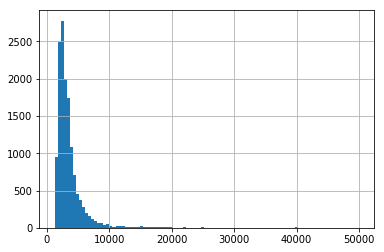

In [ ]:
raw_df['rent'].hist(bins=100)

### Seperate all features into continuous, categorical and binary features.

For those none relatived features as below, we have excluded them from the features grouping: 
- addr_unit: no relationship
- building_id: no relationship
- addr_lat: hard to analyze latitude
- addr_lon: hard to analyze longtitude
- bin: need to wait for external dataset
- bbl: need to wait for external dataset
- description: hard to build a NLP model
- unit: no relationship


In [ ]:
continuous_features =['bathrooms','bedrooms','size_sqft','floor_count','year_built','min_to_subway','floornumber' ]
caterigal_features =['addr_street','addr_city','addr_zip','neighborhood','borough','line' ]
binary_features = ['has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets', 
                   'has_washer_dryer','has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
                   'has_childrens_playroom', 'no_fee', ]

## Import external dataset from Internal Revenue Service
 - We will import the 2017 individual income Tax statistic dataset from IRS website(https://www.irs.gov/pub/irs-soi/17zpallagi.csv).
 - We will expend a new feature: **average_income** based on zipcode to our raw dataset 

In [ ]:
raw_income_data=pd.read_csv('https://www.irs.gov/pub/irs-soi/17zpallagi.csv', index_col=0)
raw_income_data.columns

In [ ]:
raw_income_data.describe()

### Income Dataset Description 
This dataset comes from the IRS website's 2017 ZIP Code Data (SOI) about Individual Income Tax Statistics.
According to the documentation's overview,the Statistics of Income (SOI) Division’s ZIP code data is tabulated using individual income tax returns (Forms 1040) filed with the Internal Revenue Service (IRS) during the 12-month period, January 1, 2018 to December 31, 2018.
The original dataset contains many income and Tax Items, we only keep the ones that are relevant: 
- STATEFIPS:The State Federal Information Processing System (FIPS) code
- STATE: The State associated with the ZIP code
- ZIPCODE: 5-digit Zip code
- agi_stub: Size of adjusted gross income
- N1: Total number of returns
- A02650: Number of returns with total income

Our goal is to find the average income of each zipcode.

### Clean the raw income data and rename feature

In [ ]:
raw_income_data = raw_income_data.loc[raw_income_data['STATE']=='NY']
raw_income_data.rename(columns = {'N1':'total_returns', 'A02650':'total_income'}, inplace = True) 
raw_income_data = raw_income_data[['STATE','zipcode','agi_stub','total_returns', 'total_income']]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']<99999]
raw_income_data = raw_income_data.loc[raw_income_data['zipcode']>0]


### Function to calculate the average income by zip code
Each zip code has 6 different sizes of adjusted gross income which means we have 6 different number of total returns and total income for one zip code.
By using the np.where and sum function, we can obtain the sum of income and sum of returns for each zip code. The income of the original dataset was in thousands of dollar so we need to multiply the sum of income by 1000 and then find the average. Since some zip code was not in the original set, we ingore those average that is NaN and only write the meaningful averages to csv file for future use.

- Calculate average income 
- Export to ny_income_2017.csv for storage
- For next time, no need to import the raw_income_dataset again

In [ ]:
average_income = pd.DataFrame({'addr_zip':[],'zip_average_income':[]})

def calculate_avg_income():
    global average_income
    for zipcode in range(10001, 14906):
        current_sum=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_income'],0).sum()
        current_returns=np.where(raw_income_data['zipcode']==zipcode, raw_income_data['total_returns'],0).sum() 
        if(current_returns <=0 or current_sum<=0):
            continue
        avg_income=(current_sum*1000)/current_returns
        new_row={'addr_zip':zipcode,'zip_average_income':avg_income}
        average_income=average_income.append(new_row,ignore_index=True)           
calculate_avg_income()
average_income.head(5)

 - We realize that the income dataset is missing all income data between zipcode 11239 - 11354, we will take an averge of zipcode income for 11239 and 11354 to replace any zipcode income in between 
 - In our training and testing dataset, only the zipcode income 11249 is missing

In [ ]:
print(list(set(raw_df['addr_zip']) - set(average_income['addr_zip'])))
print(list(set(raw_test_df['addr_zip']) - set(average_income['addr_zip'])))

**Insert a new row for zipcode income 11249 into the average_income dataframe**

In [ ]:
avg_income = (average_income.loc[(average_income['addr_zip']==11239)].iloc[0]['zip_average_income'] +
             average_income.loc[(average_income['addr_zip']==11354)].iloc[0]['zip_average_income'])/2
new_row = {'addr_zip':11249,'zip_average_income':avg_income}
average_income=average_income.append(new_row,ignore_index=True)  

### Merge the raw train  dataset with the income dataset by addr_zip

In [ ]:
raw_test2_df=raw_test_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')
raw_df=raw_df.reset_index().merge(average_income, how="left",on='addr_zip').set_index('rental_id')

### Find zip_average_income and rent cooleration

In [ ]:
continuous_features.append('zip_average_income')

In [ ]:
continuous_df = raw_df[['zip_average_income','rent']]
continuous_df.corr()['rent'][:-1]


**The correlation between zip_average_income and rent is 0.393228, it is good enough to consider as a important feature that might impact the rent**

# Data Cleaning


### Handling missing data
In order to handle missing data in this dataset, we frist find and count all the null values.

In [ ]:
raw_df.isna().sum()

As we can see from the result,there are missing data appearing on: 
- addr_unit
- bin 
- year_built 
- min_to_subway 
- description 
- neighborhood 
- unit 
- floornumber 
- line 

Continuous features floornumber, year_built and min_to_subway has impact on the rent, so we will fill with mode or mean. For catagorigious feature neighborhood, we will not use it in building model, because it has too many possible values.

In [ ]:
md_df = raw_df

md_df['floornumber'].fillna(md_df['floornumber'].mode()[0], inplace=True)
raw_test2_df['floornumber'].fillna(raw_test2_df['floornumber'].mode()[0], inplace=True)

md_df['min_to_subway'].fillna(md_df['min_to_subway'].mean(), inplace=True)
raw_test2_df['min_to_subway'].fillna(raw_test2_df['min_to_subway'].mean(), inplace=True)

md_df['year_built'].fillna(md_df['year_built'].mean(), inplace=True)
raw_test2_df['year_built'].fillna(raw_test2_df['year_built'].mean(), inplace=True)

print("original shape of dataset:",raw_df.shape)
print("shape of dataset after handling missing data, should stay the same:",md_df.shape)

## Remove outliers

In [ ]:
for feature in continuous_features:
    md_df.plot.scatter(feature, 'rent')

In [ ]:
md_df[md_df['rent']>40000].count()

**drop size_sqrt = 0 for now, since there are 713 rows, might replace with mode when creating models**

In [ ]:
def remove_outliers(md_df, feature, low_value, high_value):
    print(feature, ': ', md_df.shape)
    md_df = md_df[md_df[feature]>low_value]
    md_df = md_df[md_df[feature]<=high_value]
    md_df.reset_index(drop=True,inplace=True)
    print(feature, ': ', md_df.shape)
    return md_df

md_df = remove_outliers(md_df, 'rent', 0, 40000)
md_df = remove_outliers(md_df, 'bathrooms', 0, 12)
md_df = remove_outliers(md_df, 'size_sqft', 0, 10000)
md_df = remove_outliers(md_df, 'year_built', 1700, 2019)
md_df = remove_outliers(md_df, 'min_to_subway', 0, 60)
md_df = remove_outliers(md_df, 'floornumber', 0, 60)

md_df['year_built'] = 2019 - md_df['year_built'].astype(int)

### Encode categorical feature and drop useless features

In [ ]:
boroughs = np.array(md_df['borough'].unique())

for borough in boroughs:
    md_df[borough] = md_df['borough'].apply(lambda x : int(x == borough))
    raw_test2_df[borough] = raw_test2_df['borough'].apply(lambda x : int(x == borough))

features_notNeed = ['addr_unit', 'building_id', 'created_at', 'addr_street', 'addr_city', 'addr_zip', 'bin', 'bbl', 'description', \
                    'neighborhood', 'unit', 'borough', 'line']

md_df = md_df.drop(features_notNeed, axis=1)

### Use pair coorelation for continuous features

In [ ]:
continuous_df = md_df[continuous_features+['rent']]
continuous_df.corr()['rent'][:-1]

### Check coorelation for binary features

In [ ]:
md_df[binary_features+['rent']].corr()['rent'][:-1]
coor_results= []

for feature in binary_features:
  df = raw_df.groupby([feature]).aggregate(['mean'])['rent']
  df[feature]= df.index
  coor_results.append(df.corr().iloc[0][1])
coor_df = pd.DataFrame({'Coorelation': coor_results,'Feature':binary_features})
coor_df


As we can see in the correlation table, all binrary features highly affected the rents. When we build the models, we should include all binary features.

# Build Models
 - We will be using cross validation to evaluate the performances of our all modles,and then deciding which should be the most suitable one, thus we will first create a function called get_cv_results to obtain the cv_performance.
 - we will try 5 different basic categorical models:`multiple regression, decision tree, random froest, Gradient Boosting Regression and Neural Network`

In [ ]:
md_df = shuffle(md_df).reset_index(drop=True)


In [ ]:
features = list(md_df.columns)
features.remove('rent')
k_fold = KFold(n_splits=10)

In [ ]:
def get_cv_results(regressor):
    
    results = []
    for train, test in k_fold.split(md_df):
        regressor.fit(md_df.loc[train, features], md_df.loc[train, 'rent'])
        y_predicted = regressor.predict(md_df.loc[test, features])
        accuracy = mean_squared_error(md_df.loc[test, 'rent'], y_predicted)**0.5
        results.append(accuracy)

    return np.mean(results), np.std(results)

### Radnom Forest Model

In [ ]:
rforest = RandomForestRegressor(
    random_state=11, 
    max_depth=10,
    n_estimators=200
)


In [ ]:
get_cv_results(rforest)

In [ ]:
rforest.fit(md_df[features], md_df['rent'])  
for feature,score in sorted(zip(features,rforest.feature_importances_), key=lambda x:x[1], reverse=True):
    print(feature, ' ', score)

### Multiple Regression
 - Multiple regression is an extension of simple linear regression. It is used when we want to predict the value of a variable based on the value of two or more other variables
 - We will based on p value to choose significant variables(p<0.1)
 

In [ ]:
mul_reg_features = features[:]
x = md_df[features] 
y = md_df['rent']
est = sm.OLS(y, x).fit()
est.summary()

- As we can see, variables has_garden and year_built have P value > 0.1
- After we remove these two variables, all P values are < 0.1

In [ ]:
mul_reg_features.remove('has_garden')
mul_reg_features.remove('year_built')
x = md_df[mul_reg_features] 
y = md_df['rent']
est = sm.OLS(y, x).fit()
est.summary()

In [ ]:
mul_reg = LinearRegression().fit(md_df[mul_reg_features], md_df['rent'])
get_cv_results(mul_reg)

## Gradient Boosting Regression
For the gradient boosting regressor we will first set up the hyperparameter max_depth=5 to avoid overfitting, will adjust more hyperparameter as we move on to improve the model


In [ ]:
gbrdemo = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=100
)

get_cv_results(gbrdemo)

### Tuning Hyperparameters
Now let's use GridSearchCV form sci-kit learn model_selection to tune the hyperparameters, and find the most suitable one for our Gradient Boosting Regression model.

In [ ]:
# Tuning the hyperparameters based on a cross-validation subset (cv)
# cited link: link: https://shankarmsy.github.io/stories/gbrt-sklearn.html

def GradientBooster():
    
    param_grid={'n_estimators':[100],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth':[4, 5, 6],
            'min_samples_leaf':[3, 5, 9],
           }
    
    # choose cross validation generator and use ShuffleSplit which randomly shuffles and selects Train and CV sets
    cv = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
    
    classifier = GridSearchCV(estimator = GradientBoostingRegressor(), param_grid=param_grid, n_jobs=4, cv=cv)
    
    classifier.fit(md_df[features], md_df['rent'])  
    return classifier.best_params_

In [ ]:
# Since this function takes too long to run, it will waste a lot of time during development,
# so we will just record the result for further usage. -----Runmin 11/18/19
"""
best_est=GradientBooster()

print("Best Estimator Parameters:")
print("n_estimators: ",best_est['n_estimators'])
print("max_depth: ", best_est['max_depth'])
print("Learning Rate: ", best_est['learning_rate'])
print("min_samples_leaf: ", best_est['min_samples_leaf'])
"""
print("Since this function takes too long to run, it will waste a lot of time during development,\
      \nso we will just record the result for further usage:")
print("\nBest Estimator Parameters:")
print("n_estimators: ",100)
print("max_depth: ", 6)
print("Learning Rate: ", 0.1)
print("min_samples_leaf: ", 3)

As we can see from the result above, we have found the suitable hyperparameters for our model, thus we can use them to check if a better result will be obtained.


In [ ]:
bettergbr1 = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    min_samples_leaf=3
)

get_cv_results(bettergbr1)

We do see some improvements on the mean squared error after we adjusted the hyperparameter a bit

##  Regression Tree Model
From definition, decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.
Thus, in our case when we do the regression tree model, we actually use the decision tree classifer.

Train the regression model using default paramater

In [ ]:
regtreemo = DecisionTreeRegressor(
    random_state=1, 
    max_depth=None,
    min_samples_leaf=1,
    max_features=None,
    max_leaf_nodes=None )

regtreemo.fit(md_df[features], md_df['rent'])

In [ ]:
get_cv_results(regtreemo)

Train the regression model using Hyperparameters that we found, so that we can compare the results among different models better.

In [ ]:
newregtreemo = DecisionTreeRegressor(
    random_state=1, 
    max_depth=6,
    min_samples_leaf=3 )

newregtreemo.fit(md_df[features], md_df['rent'])

In [ ]:
get_cv_results(newregtreemo)

In [ ]:
As we can see, the regression tree model that uses the Hyperparameters does have better result.

In [ ]:
for feature,score in zip(features,newregtreemo.feature_importances_):
    print(feature, ' ', score)

### Learning Curve
We can use the Learning Curves methods provided in lecture 8

In [ ]:
hp_values = range(1,50, 2)
all_mu = []
all_sigma = []

for m in hp_values:

    dtree=DecisionTreeClassifier(
        criterion='entropy', 
        random_state=random_state, 
        max_depth=m,
    )

    mu, sigma = get_cv_results(dtree)
    all_mu.append(mu)
    all_sigma.append(sigma)
    
    print(m, mu, sigma)

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_mu)
plt.ylabel('Cross Validation Accuracy')
plt.xlabel('Max Depth')

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(hp_values, all_sigma)
plt.ylabel('Cross Validation Std Dev.')
plt.xlabel('Max Depth')

### Neural Network
Neural networks are a set of algorithms, modeled loosely after the human brain, that are designed to recognize patterns. They interpret sensory data through a kind of machine perception, labeling or clustering raw input.(source:https://skymind.ai/wiki/neural-network)

In [53]:
scaler = StandardScaler()
X = scaler.fit_transform(md_df[features])
Y = md_df['rent'].values.reshape(-1,1)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [54]:
net = models.Sequential()
net.add(layers.Dense(64, input_dim=train_x.shape[1], kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(64, kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.1), activation='relu'))
net.add(layers.Dropout(0.1))

net.add(layers.Dense(1, activation='linear'))

net.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

In [55]:
net.fit(train_x, train_y, epochs=150, batch_size=64, validation_split = 0.1)

Train on 9169 samples, validate on 1019 samples
Epoch 1/150
9169/9169 [==============================] - 1s 62us/step - loss: 9439488.9872 - mean_squared_error: 9439101.0000 - val_loss: 4170506.5745 - val_mean_squared_error: 4170093.7500
Epoch 2/150
9169/9169 [==============================] - 0s 39us/step - loss: 1970723.0375 - mean_squared_error: 1970319.0000 - val_loss: 3720449.1812 - val_mean_squared_error: 3720047.7500
Epoch 3/150
9169/9169 [==============================] - 0s 39us/step - loss: 1797370.9328 - mean_squared_error: 1796976.2500 - val_loss: 3765317.5942 - val_mean_squared_error: 3764927.5000
Epoch 4/150
9169/9169 [==============================] - 0s 37us/step - loss: 1640128.9020 - mean_squared_error: 1639741.0000 - val_loss: 3692878.1021 - val_mean_squared_error: 3692495.0000
Epoch 5/150
9169/9169 [==============================] - 0s 38us/step - loss: 1695072.3071 - mean_squared_error: 1694691.1250 - val_loss: 3572261.3766 - val_mean_squared_error: 3571882.5000
Ep

Epoch 44/150
9169/9169 [==============================] - 0s 38us/step - loss: 1121335.7541 - mean_squared_error: 1120913.7500 - val_loss: 2383597.2294 - val_mean_squared_error: 2383174.5000
Epoch 45/150
9169/9169 [==============================] - 0s 36us/step - loss: 981618.4525 - mean_squared_error: 981193.0000 - val_loss: 2193254.7223 - val_mean_squared_error: 2192825.7500
Epoch 46/150
9169/9169 [==============================] - 0s 37us/step - loss: 1011763.1615 - mean_squared_error: 1011335.3125 - val_loss: 2532054.0707 - val_mean_squared_error: 2531628.0000
Epoch 47/150
9169/9169 [==============================] - 0s 37us/step - loss: 990110.7172 - mean_squared_error: 989682.6250 - val_loss: 2208455.8214 - val_mean_squared_error: 2208024.5000
Epoch 48/150
9169/9169 [==============================] - 0s 36us/step - loss: 984393.7737 - mean_squared_error: 983962.0625 - val_loss: 2231541.6372 - val_mean_squared_error: 2231108.2500
Epoch 49/150
9169/9169 [===========================

9169/9169 [==============================] - 0s 38us/step - loss: 763063.6135 - mean_squared_error: 762536.1250 - val_loss: 1957301.6408 - val_mean_squared_error: 1956773.6250
Epoch 131/150
9169/9169 [==============================] - 0s 37us/step - loss: 737854.5669 - mean_squared_error: 737323.8750 - val_loss: 1869961.2300 - val_mean_squared_error: 1869428.1250
Epoch 132/150
9169/9169 [==============================] - 0s 38us/step - loss: 663983.6154 - mean_squared_error: 663448.8750 - val_loss: 1679475.4725 - val_mean_squared_error: 1678939.2500
Epoch 133/150
9169/9169 [==============================] - 0s 37us/step - loss: 763707.5336 - mean_squared_error: 763173.5625 - val_loss: 1800012.7746 - val_mean_squared_error: 1799477.6250
Epoch 134/150
9169/9169 [==============================] - 0s 37us/step - loss: 749428.0405 - mean_squared_error: 748892.0625 - val_loss: 1981046.4145 - val_mean_squared_error: 1980511.5000
Epoch 135/150
9169/9169 [==============================] - 0s 39

In [56]:
mean_squared_error(test_y, net.predict(test_x))

1373529.171673119

**Although the DL Neural Network seems to provide a better result on mean squared errors but it is really unstable** 

we have ran few test run on it, and each time it gives different results range from 853411.6171418771 to around 1,300,000.
Therefore, we might still choose Gradient Boosting Regression as the most suitable model, since it provides a overall better result.